In [1]:
# load python packages - pep 8 specifies core packages first... third party next
import os
import numpy as np 

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent

import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es

# prettier plotting 
#import seaborn as sns 
#sns.set(font_scale=1.5)
#sns.set_style("white")

os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))
et.data.get_data("colorado-flood")


'/Users/leahwasser/earth-analytics/data/colorado-flood/.'

## Open Raster Data  Using Context Manager

In [2]:
# Because i may use the path to the data several times, i'm constructing the path in 2 steps!
data_path = os.path.join("data", "colorado-flood", "spatial", "boulder-leehill-rd")
dtm_path = os.path.join(data_path, "pre-flood", "lidar", "pre_DTM.tif")

#dtm_path = 'data/colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif'

with rio.open(dtm_path) as src:
    # reading the data into numpy as an array
    # set masked = true to import a masked array (no data values = masked)
    lidar_dtm_im = src.read(1, masked=True)
    # printing some metadata
    #print(src.bounds)
    # grab the spatial extent for plotting 
    spatial_extent = plotting_extent(src)
    metadata = src.meta
    
type(lidar_dtm_im)
lidar_dtm_im.shape
metadata

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028234663852886e+38,
 'width': 4000,
 'height': 2000,
 'count': 1,
 'crs': CRS.from_epsg(32613),
 'transform': Affine(1.0, 0.0, 472000.0,
        0.0, -1.0, 4436000.0)}

## Plot The Data 

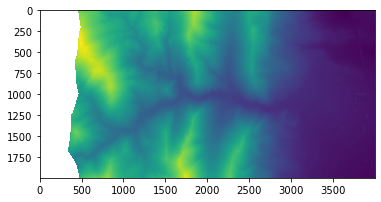

In [3]:
f, ax = plt.subplots()
ax.imshow(lidar_dtm_im)
plt.show()

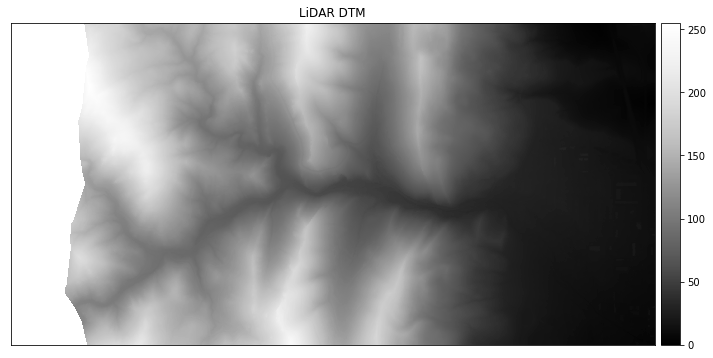

In [4]:
# Use earthpy to plot the data this will work until you want to add a custom legend

ep.plot_bands(lidar_dtm_im,
             title="LiDAR DTM",
             cmap="Greys_r")
plt.show()

In [5]:
lidar_dtm_im.shape

(2000, 4000)

## Create a Histogram of Raster Data
frequency  -- of elevations values

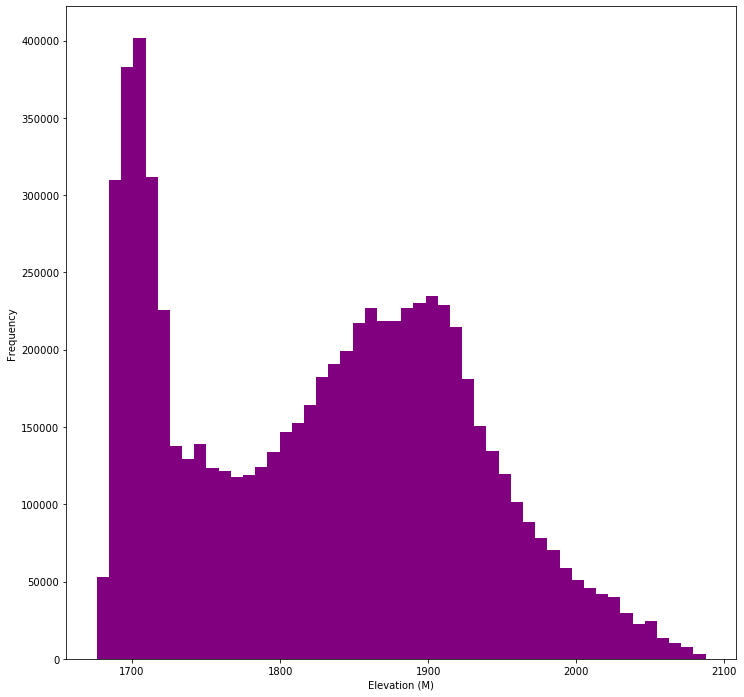

In [6]:
# Remember that you don't want to use plt.show() in your homework!!
ep.hist(lidar_dtm_im, bins = 50,
       xlabel="Elevation (M)", ylabel="Frequency")
plt.show()

## Open Digital Surface Model from the Pre Flood Data

In [7]:
# Open up pre-flood DSM
dsm_path = "data/colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DSM.tif"
with rio.open(dsm_path) as dsm_src:
    lidar_dsm_im = dsm_src.read(1, masked = True)
    spatial_extent_dsm = plotting_extent(dsm_src)
    
lidar_dsm_im.shape == lidar_dtm_im.shape
dsm_src.crs == src.crs

True

## Subtract the Rasters

In [8]:
# subtract
lidar_chm_im = lidar_dsm_im - lidar_dtm_im
# view stats 
lidar_chm_im.max(), lidar_chm_im.min()

(26.930054, 0.0)

In [9]:
# the output calculated image is a masked array
lidar_chm_im

masked_array(
  data=[[--, --, --, ..., 0.0, 0.1700439453125, 0.9600830078125],
        [--, --, --, ..., 0.0, 0.090087890625, 1.6400146484375],
        [--, --, --, ..., 0.0, 0.0, 0.0799560546875],
        ...,
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=-3.402823e+38,
  dtype=float32)

/Users/leahwasser/miniconda3/envs/earth-analytics-python/lib/python3.7/site-packages/numpy/ma/core.py:1015: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


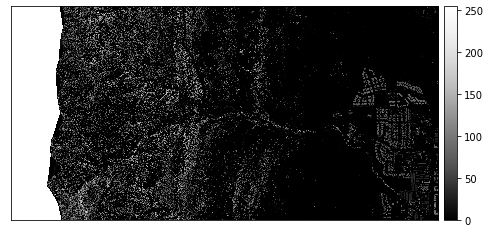

In [10]:
# The commented line below can be used if you want to interact with your raster (mouse over to view values)
#%matplotlib notebook
# TODO: This is now throwing a runtime warning... 

# plot the data - chm data 
ep.plot_bands(lidar_chm_im, figsize=(8,4))
plt.show()

## Classify The Canopy Height Model

Classify in this instance refers to reassigning values in an existing raster to another value.

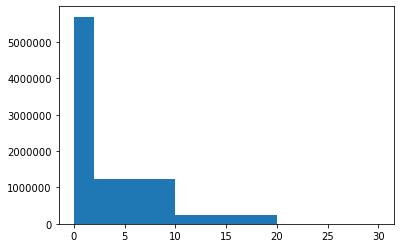

In [11]:
# plot a histogram of the data
fig, ax = plt.subplots()
ax.hist(lidar_chm_im.ravel(), 
        bins=[0,2, 10, 20, 30])
plt.show()

In [12]:
lidar_chm_im.min(), lidar_chm_im.max()
type(lidar_chm_im)

numpy.ma.core.MaskedArray

In [13]:
# classify the data using np.digitize()

# define the bins to use in classification
class_bins = [-np.inf, 0, 2, 7, 12, np.inf]
# classify your raster using numpy digitize
lidar_chm_im_class = np.digitize(lidar_chm_im, 
                                 class_bins)



In [14]:
# View unique values in the data 
np.unique(lidar_chm_im_class)

array([1, 2, 3, 4, 5])

In [15]:
# Have a look at the data
lidar_chm_im_class

array([[1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       ...,
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2]])

## Just something that might be helpful to know about

Below i use the `np.ma.masked_where()` function as an example of how to mask values if you need to. You shouldn't need to this week however.  

In [16]:
# you can turn your data into a masked array if you want
lidar_chm_class_ma = np.ma.masked_where(lidar_chm_im_class == 1, 
                              lidar_chm_im_class, 
                              copy=True)
# forcing two values to plot one line
lidar_chm_class_ma.min(), lidar_chm_class_ma.max()

(2, 5)

In [17]:
# now you have a masked array again which will plot nicely
type(lidar_chm_class_ma)

numpy.ma.core.MaskedArray

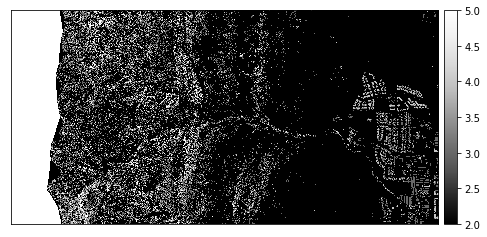

In [22]:
# plot the data!
%matplotlib inline
ep.plot_bands(lidar_chm_class_ma,
             scale=False, figsize =(8,4))
plt.show()

## Add a Custom Legend to Your Plot with EarthPy

Note that the lessons online need to be updated!! I will do this tonight or tomorrow but you can use this code as an example of how legends work with earthpy. You can also look at the earthpy docs!!

In [19]:
#  add packages to the top of your notebook always not here!
# Here i'm just showing you what additional function you need to create the colormap!
#from matplotlib.colors import ListedColormap

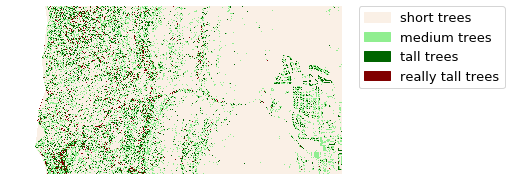

In [45]:
%matplotlib inline

colors = ['linen', 'lightgreen', 'darkgreen', 'maroon']
height_class_labels = ["short trees", "medium trees",
                       "tall trees", "really tall trees"]

# Create a colormap from a list of colors
cmap = ListedColormap(colors)

f, ax = plt.subplots()
im = ax.imshow(lidar_chm_class_ma, 
               cmap=cmap)
ep.draw_legend(im, titles=height_class_labels)
ax.set_axis_off()
plt.show()

## Cropping a raster using crop_image in earthpy 

The example above ran you through several raster operations. the one thing it skipped was cropping an image. you can do that when you import the data initially with rasterio.

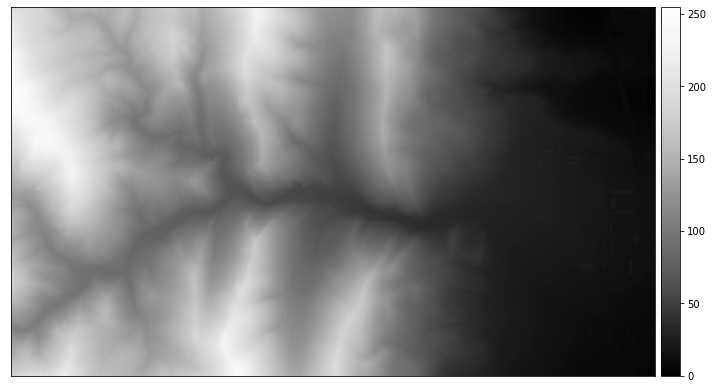

In [23]:
# Open the crop extent that need to crop the data!
clip_extent_path = os.path.join(data_path, "clip-extent.shp")
crop_extent = gpd.read_file(clip_extent_path)

with rio.open(dtm_path) as pre_dtm:
    pre_dtm_crop, _ = es.crop_image(pre_dtm, crop_extent)

# Plot the cropped data
ep.plot_bands(pre_dtm_crop)
plt.show()